PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True
using device: cuda
01190626V001


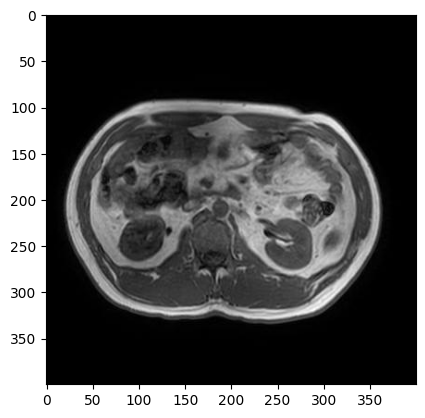

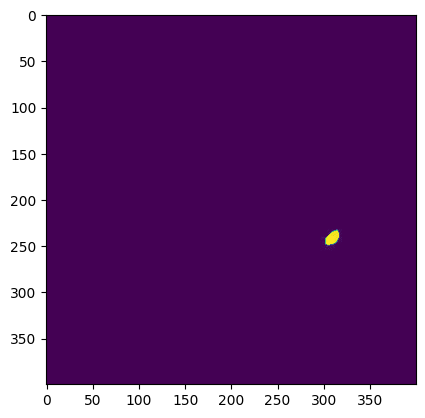

[[296 253 297 254]]
[[296 248 297 249]]
[[296 245 298 247]]
[[304 232 307 235]]
[[296 232 320 256]]


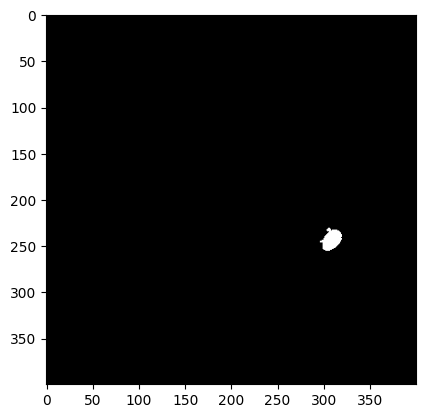

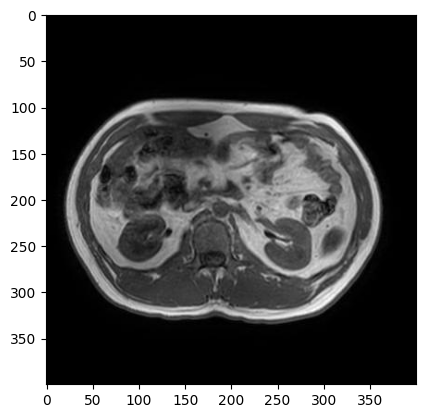

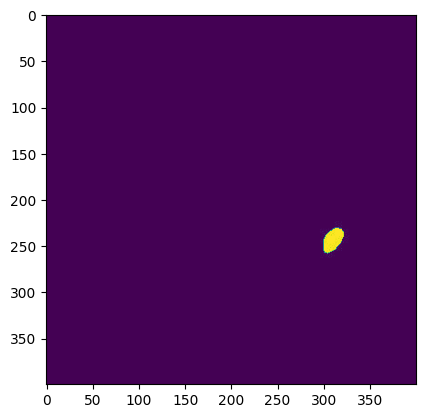

[[297 256 298 257]]
[[319 255 320 256]]
[[310 263 311 264]]
[[311 261 312 262]]
[[296 224 328 264]]


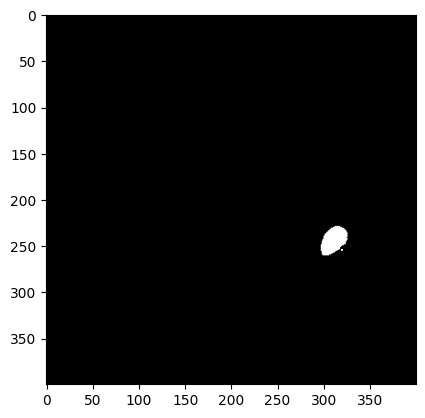

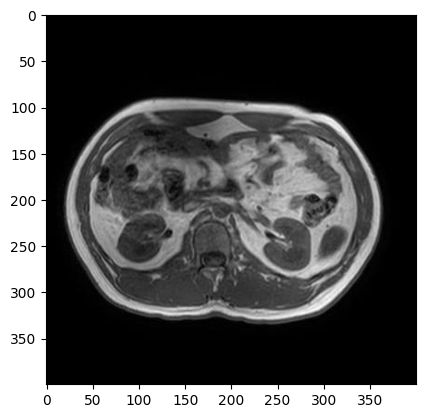

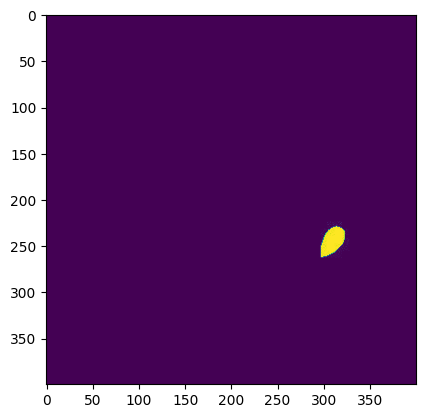

[[327 255 328 256]]
[[319 263 320 264]]
[[327 247 328 249]]
[[296 224 328 264]]


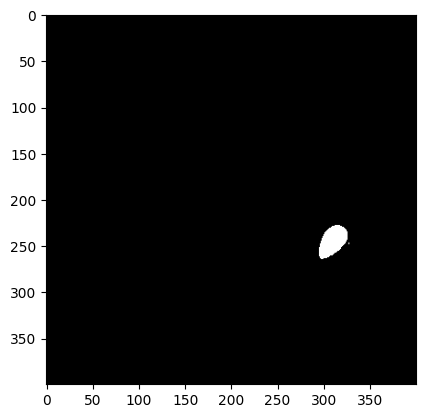

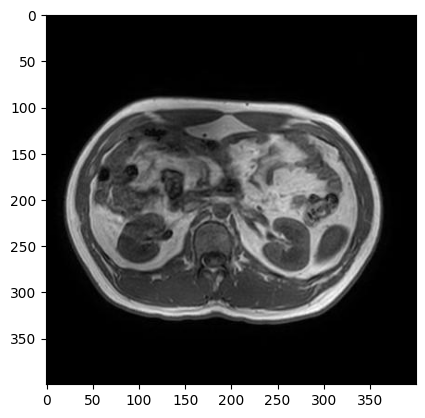

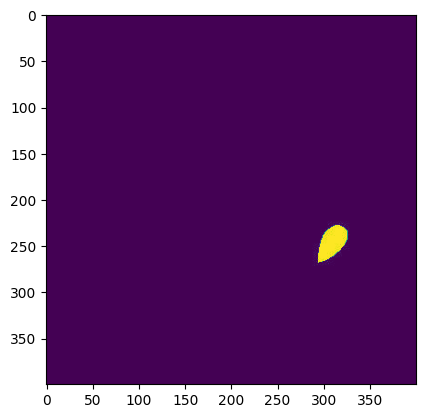

[[306 229 307 230]]
[[319 263 320 264]]
[[311 269 312 270]]
[[296 232 298 235]]
[[316 257 320 262]]
[[288 224 328 272]]


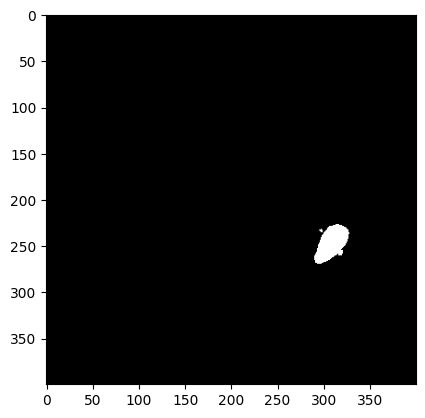

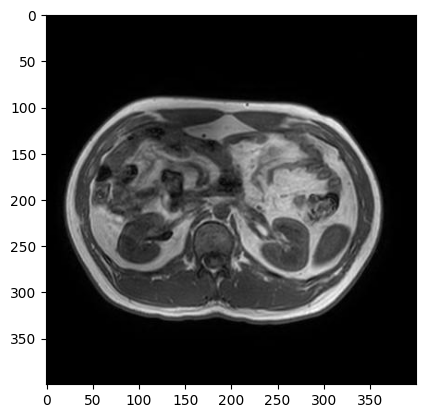

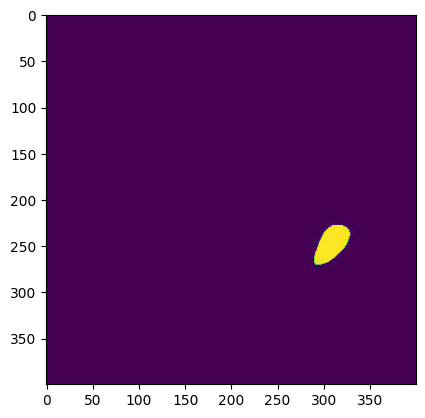

[[311 225 312 226]]
[[327 224 328 226]]
[[288 224 336 272]]


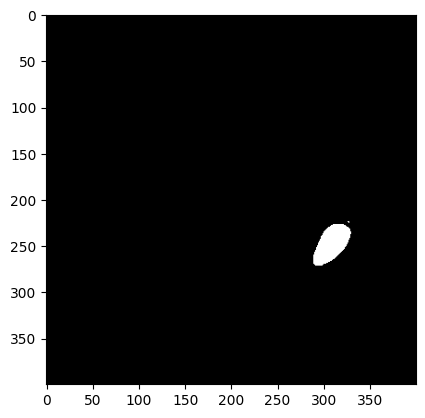

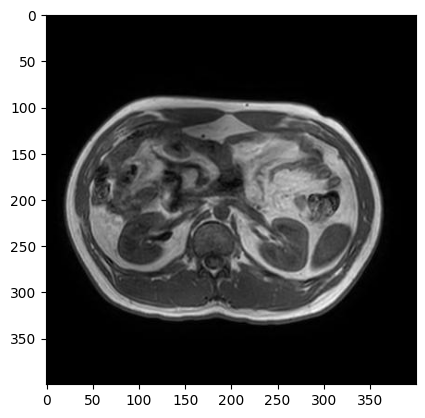

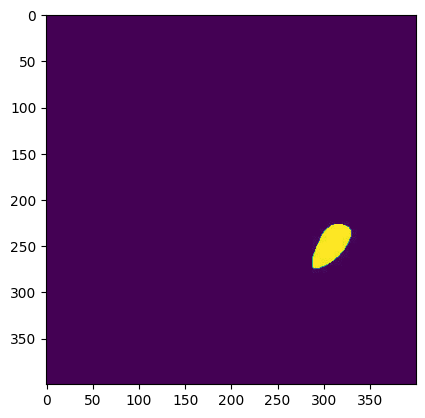

[[327 263 328 264]]
[[319 271 320 272]]
[[304 224 305 226]]
[[293 277 297 280]]
[[288 224 336 280]]


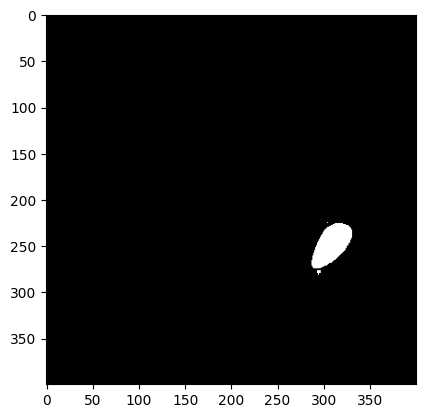

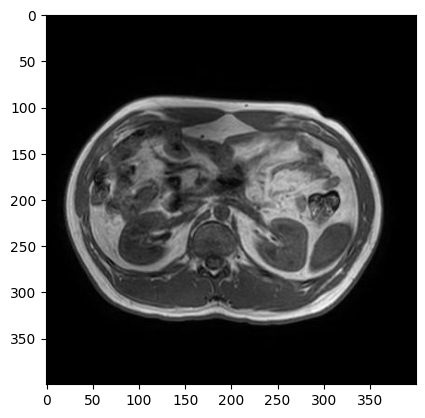

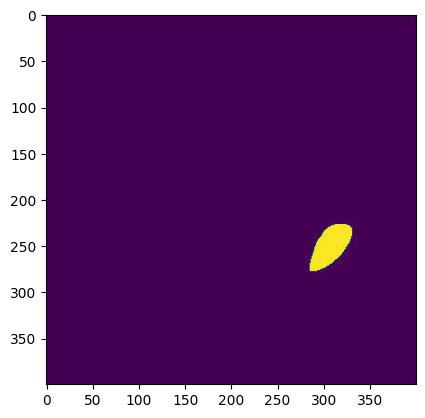

[[316 270 320 272]]
[[330 224 336 230]]
[[280 224 336 280]]


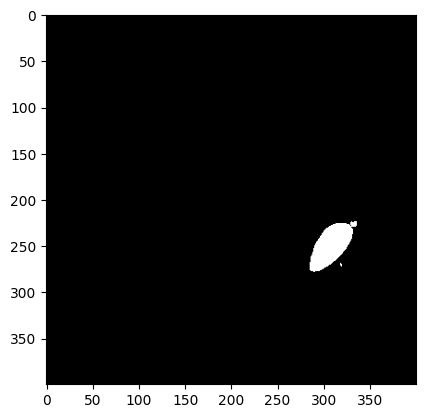

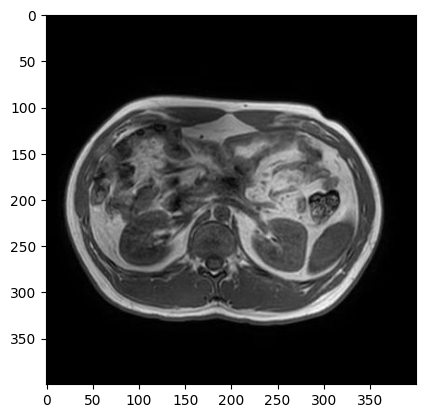

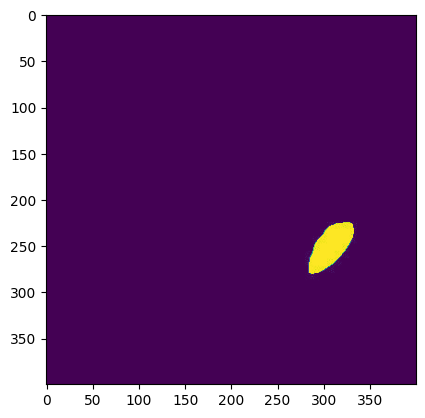

[[335 224 336 225]]
[[280 280 281 281]]
[[295 285 296 286]]
[[280 285 281 286]]
[[287 283 289 284]]
[[288 240 290 243]]
[[308 278 312 280]]
[[322 258 328 264]]
[[280 224 336 288]]


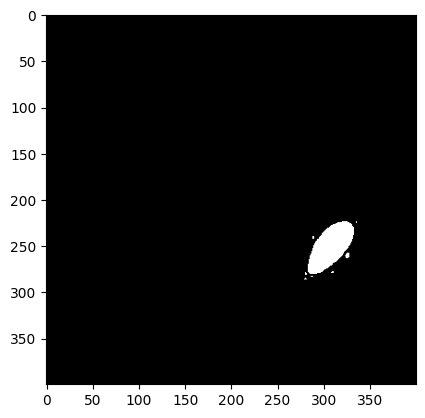

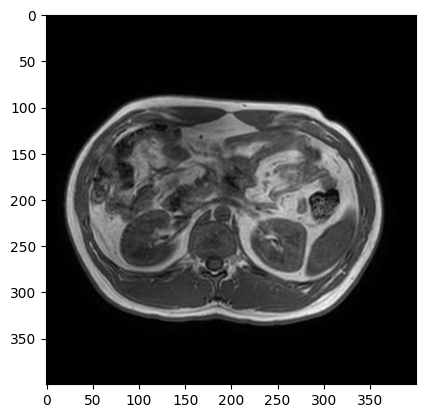

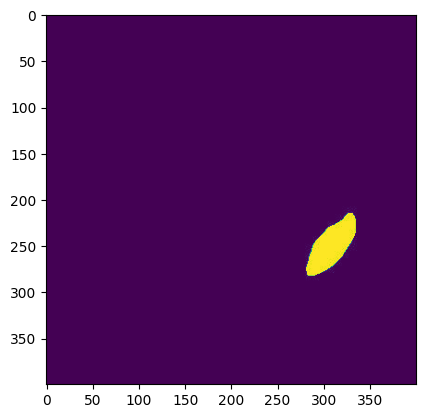

[[312 218 313 219]]
[[320 210 321 211]]
[[291 240 292 241]]
[[335 238 336 239]]
[[280 248 281 249]]
[[335 248 336 249]]
[[283 287 284 288]]
[[335 255 336 256]]
[[287 286 290 288]]
[[280 208 336 288]]


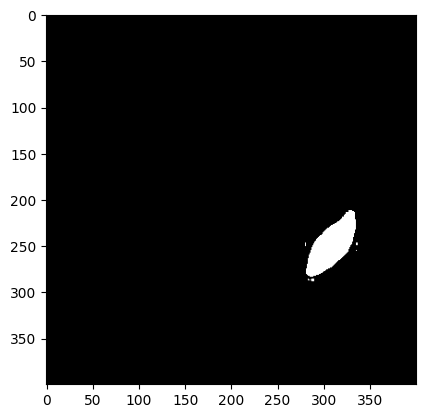

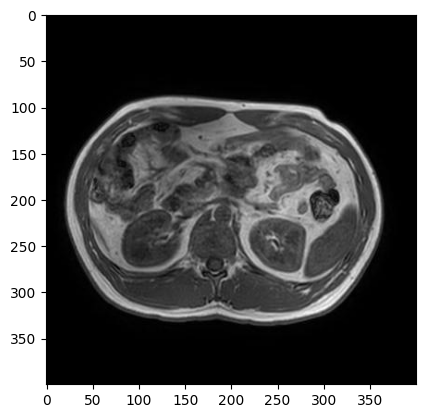

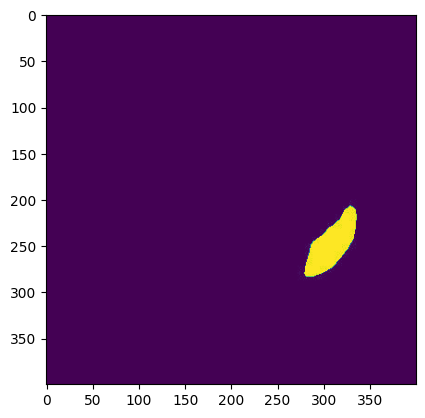

[[328 204 329 205]]
[[335 202 336 203]]
[[327 258 328 259]]
[[335 235 336 236]]
[[319 271 320 272]]
[[291 287 292 288]]
[[303 285 304 286]]
[[272 272 273 273]]
[[272 287 273 288]]
[[272 279 273 281]]
[[335 207 336 209]]
[[278 285 281 288]]
[[272 200 336 288]]


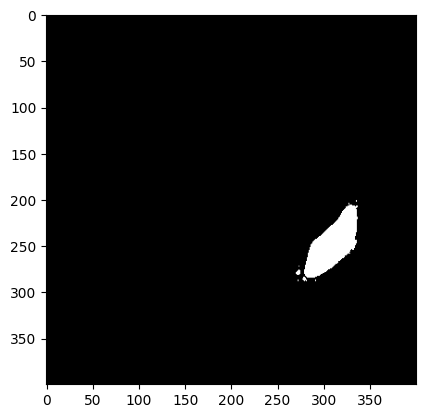

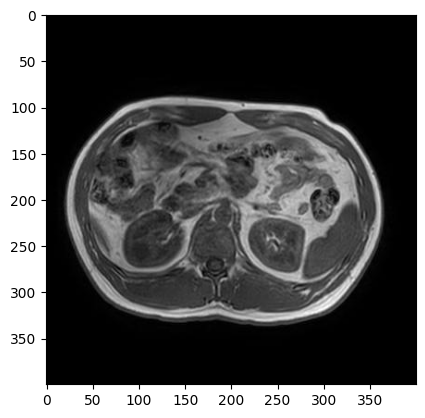

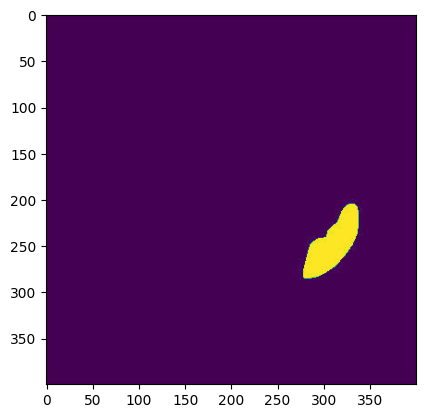

[[328 200 329 201]]
[[312 208 313 209]]
[[312 222 313 223]]
[[319 279 320 280]]
[[319 268 320 269]]
[[272 264 273 265]]
[[280 255 281 256]]
[[280 240 281 241]]
[[303 285 304 286]]
[[272 274 273 275]]
[[290 287 291 288]]
[[288 287 289 288]]
[[302 287 303 288]]
[[294 287 295 288]]
[[304 224 305 226]]
[[334 200 336 202]]
[[341 208 344 210]]
[[341 236 344 240]]
[[272 200 344 288]]


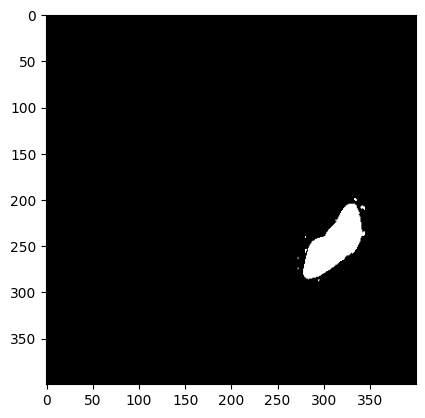

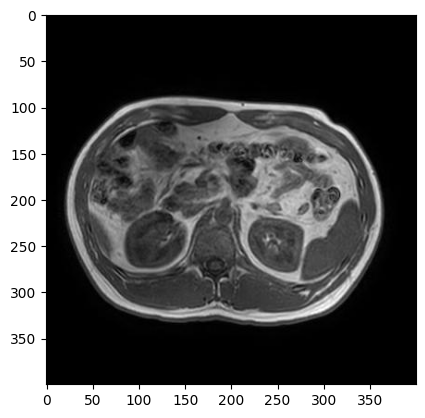

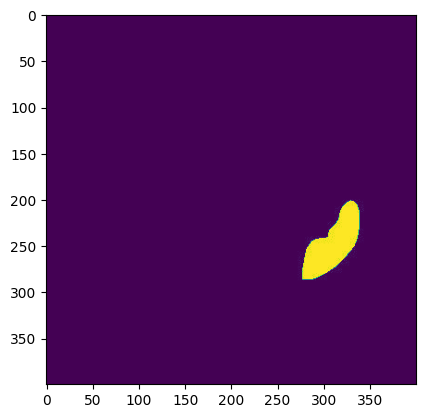

[[312 208 313 209]]
[[335 263 336 264]]
[[272 256 273 257]]
[[343 247 344 248]]
[[303 285 304 286]]
[[320 200 323 203]]
[[272 200 344 288]]


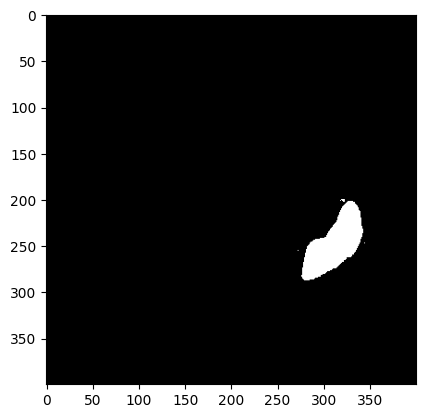

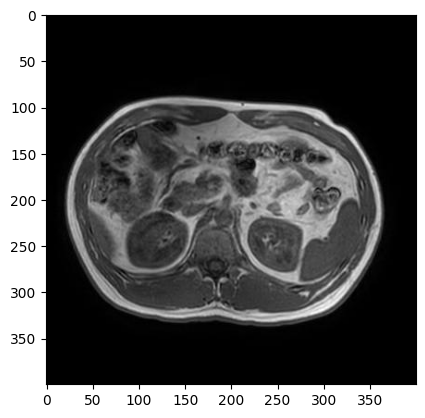

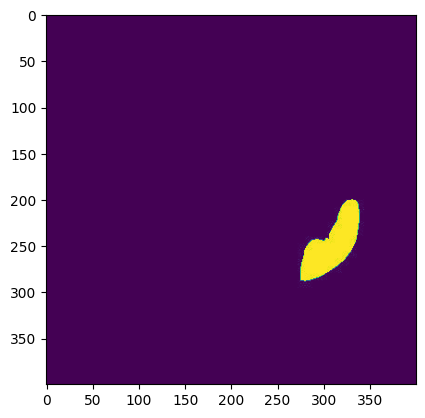

[[343 200 344 201]]
[[272 248 273 249]]
[[287 295 288 296]]
[[272 295 273 296]]
[[303 286 304 288]]
[[312 218 313 220]]
[[316 278 320 280]]
[[278 293 282 296]]
[[272 200 344 296]]


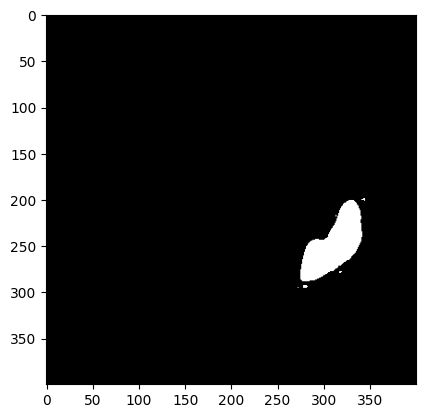

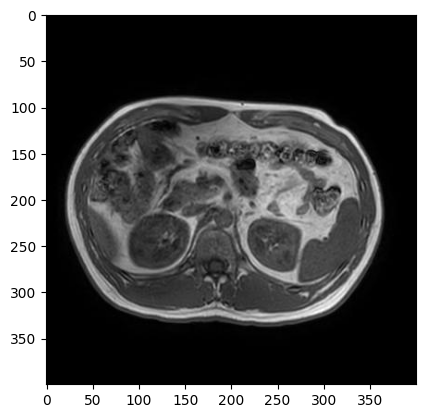

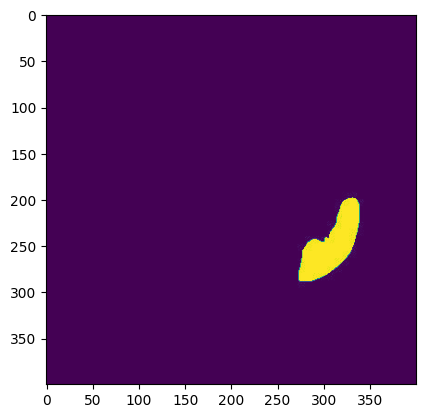


KeyboardInterrupt



In [2]:
# MRI-切片分割样本
import cv2
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import os

# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
np.random.seed(3)


def cal_subject_level_dice(prediction, target, class_num=2):# class_num是你分割的目标的类别个数
    '''
    step1: calculate the dice of each category
    step2: remove the dice of the empty category and background, and then calculate the mean of the remaining dices.
    :param prediction: the automated segmentation result, a numpy array with shape of (h, w, d)
    :param target: the ground truth mask, a numpy array with shape of (h, w, d)
    :param class_num: total number of categories
    :return:
    '''
    eps = 1e-10
    empty_value = -1.0
    dscs = empty_value * np.ones((class_num), dtype=np.float32)
    for i in range(0, class_num):
        if i not in target and i not in prediction:
            continue
        target_per_class = np.where(target == i, 1, 0).astype(np.float32)
        prediction_per_class = np.where(prediction == i, 1, 0).astype(np.float32)

        tp = np.sum(prediction_per_class * target_per_class)
        fp = np.sum(prediction_per_class) - tp
        fn = np.sum(target_per_class) - tp
        dsc = 2 * tp / (2 * tp + fp + fn + eps)
        dscs[i] = dsc
    dscs = np.where(dscs == -1.0, np.nan, dscs)
    subject_level_dice = np.nanmean(dscs[1:])
    return subject_level_dice

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# 配置模型
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from thop import profile
sys.path.append("./segment-anything-2")
sys.path.append("./segment-anything-2/checkpoints")
sys.path.append("./segment-anything-2/sam2_configs")
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "sam2.1_hiera_l.yaml" # 只能用文件名，不可以用路径，所以要事先添加path

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)


# 数据预处理
import time
time0 = time.time()


IDs=['01190626V001']
organ_heart = []
for ID in IDs:
        print(ID)
    # if not os.path.exists("/cpfs01/projects-HDD/cfff-6117e6302119_HDD/wangchengyan/segment-anything-2/"+ID+"/DICE_SAM2_MRI.xlsx"):
        result_dice = []
        result_dice.append(ID)
        organs = ['spleen','liver', 'kidney', 'pancreas', 'IVC']
        for organ in organs:

            path_label = "./DataSample/"+ID+"/label_"+organ+"/label_"+organ+".nii.gz"
            video_dir = "./DataSample/"+ID+"/image_abdomen/mDIXON-All_BH_in_phase.nii.gz"


            if os.path.exists(path_label) and os.path.exists(video_dir):
                example_label_file = os.listdir(path_label)[0]
                example_image_file = os.listdir(video_dir)[0]


                if '_' in example_label_file:
                    # 说明没有转换成功，看是转换
                    for file in os.listdir(path_label):
                        file_path = path_label +"/" + file
                        # print(file_path)
                        # print(path_label +"/" + file.split('_')[2])
                        os.rename(file_path, path_label+"/"+file.split('_')[2])

                if '_' in example_image_file:
                    # 说明没有转换成功，看是转换
                    for file in os.listdir(video_dir):
                        file_path = video_dir +'/' + file
                        # print(file_path)
                        # print(video_dir+"/"+file.split('_')[-1])
                        os.rename(file_path, video_dir+"/"+file.split('_')[-1])
                frame_names = [
                    p for p in os.listdir(video_dir)
                    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
                ]
                frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
                # print(frame_names) # 排好序的jpg文件

                image_batch = []
                bbox_batch = []

                from PIL import Image
                import time
                time1 = time.time()
                for file in frame_names:
                    this_bboxes = []
                    path_image_file = video_dir + '/' + file
                    # print(path_image_file)
                    path_label_file = path_label + '/' + file
                    # print(path_label_file)

                    mask = cv2.imread(path_label_file, 0)
                    retval, _, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
                    # print(stats)
                    retval=retval-1
                    if retval>0:
                        image = Image.open(path_image_file)
                        image = np.array(image.convert("RGB"))
                        
                        plt.imshow(image)
                        plt.show()
                        
                        plt.imshow(mask)
                        plt.show()
                        predictor.set_image(image)
                        ind=stats[:, 4].argsort()
                        stats = stats[ind][:-1]
                        for i in range(retval):
                            input_bbox = np.array([[stats[i][0], stats[i][1], stats[i][0]+stats[i][2], stats[i][1]+stats[i][3]]])
                            this_bboxes.append(input_bbox)
                            print(input_bbox)
                            top_left = int(input_bbox[0][0]), int(input_bbox[0][1])  
                            under_right = int(input_bbox[0][2]), int(input_bbox[0][3])
                            x1, y1 = top_left
                            x2, y2 = under_right  
                            
                            box_color = 1
                            # print(np.max(image))
                            image_bbox = np.array(Image.open(path_image_file).convert("RGB"))
                            
                            image_bbox[y1-1:y1+1, x1-1:x2+1] = box_color*255
                            # 绘制下边框
                            image_bbox[y2-1:y2+1, x1-1:x2+1] = box_color*255
                            # 绘制左边框
                            image_bbox[y1-1:y2+1, x1-1:x1+1] = box_color*255
                            # 绘制右边框
                            image_bbox[y1-1:y2+1, x2-1:x2+1] = box_color*255
                            
                            # plt.imshow(image_bbox)
                            # plt.show()



                        masks, scores, _ = predictor.predict(
                            point_coords=None,
                            point_labels=None,
                            box=this_bboxes,
                            multimask_output=False,
                        )

                        pre_merge = np.zeros(image.shape, dtype=np.uint8)
                        # print('image_shape', image.shape)
                        for i in range(masks.shape[0]):
                            this_mask = masks[i]
                            # print('this_mask_shape', this_mask.shape)
                            h,w = this_mask.shape[-2:]
                            predict_mask = this_mask.reshape(h, w, 1).astype(np.uint8) * np.array(
                                                            [255, 255, 255], dtype=np.uint8)
                            pre_merge = cv2.add(pre_merge, predict_mask)
                        plt.imshow(pre_merge)
                        plt.show()


